In [5]:
import time
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim import models
import scipy.io
from sklearn.decomposition import PCA as pca
from sklearn.manifold import TSNE as tsne
import umap
from keras.datasets import mnist, fashion_mnist

In [ ]:
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv"
df = pd.read_csv(url, sep = '\t')
df.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98


#### 1. Вывести: кол-во наблюдений в датасете

In [ ]:
df.shape[0]

4622

#### 2. Вывести названия столбцов

In [ ]:
print(*df.columns, sep = ', ')

order_id, quantity, item_name, choice_description, item_price


#### 3. Определить самую частую позицию (item) в заказе 

In [ ]:
print(*df['item_name'].mode())

Chicken Bowl


#### 4. Построить гистрограмму частоты заказов по позициям (item)

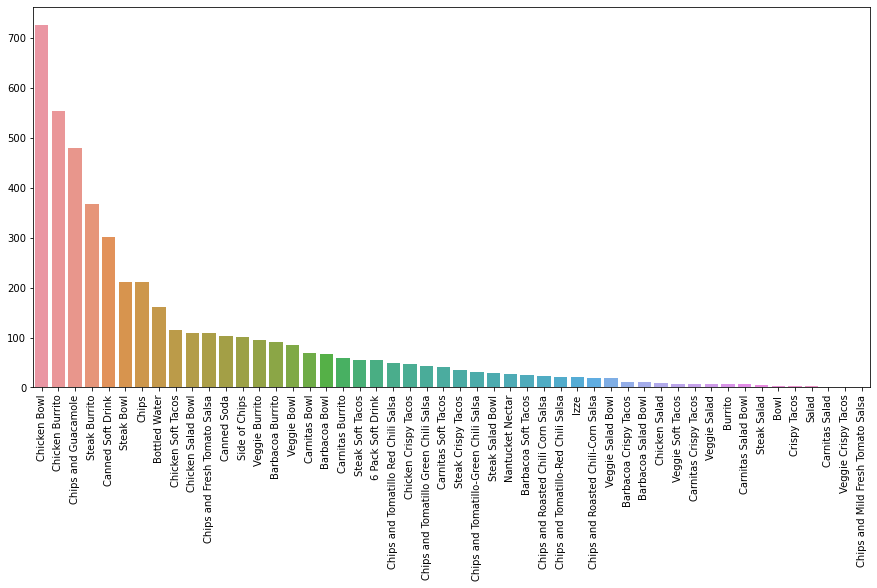

In [ ]:
item_count = df['item_name'].value_counts()
plt.figure(figsize=(15,7))
sns.barplot(item_count.index, item_count.values)
plt.xticks(rotation=90)
plt.show()

#### 5. Измените тип переменной item_price c с помощью лямбды функции

In [ ]:
df['item_price'] = df['item_price'].apply(lambda x: float(x[1:]))

#### 6. Построить гистограмму кол-во денег заработанных по каждой позиции (item)

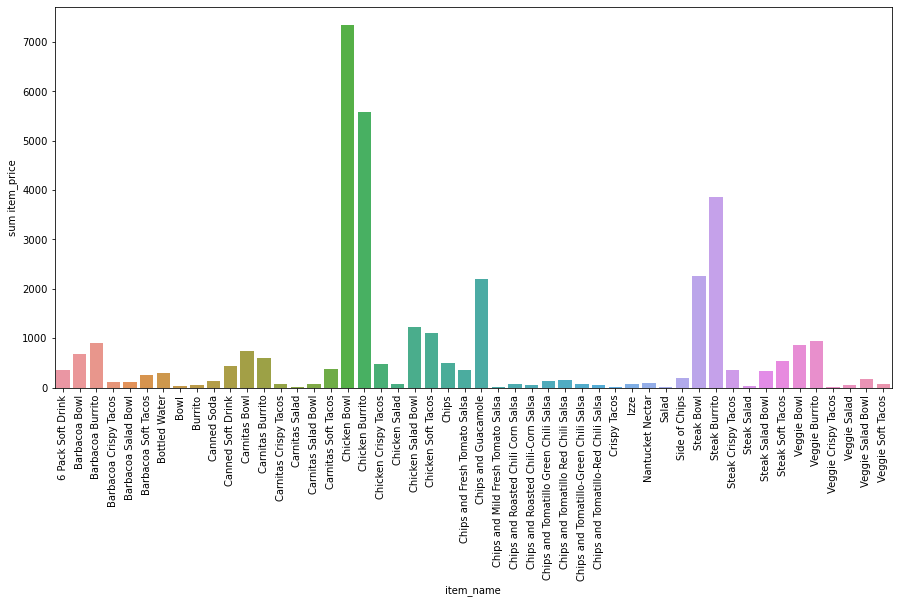

In [ ]:
item_cost = df.groupby(['item_name']).sum()
plt.figure(figsize=(15,7))
sns.barplot(item_cost.index, item_cost.item_price)
plt.ylabel('sum item_price')
plt.xticks(rotation=90)
plt.show()

#### 7. Средняя сумма заказа? (минимум 2 способа)

In [ ]:
round(df.groupby(['order_id']).sum().mean().item_price, 2)

18.81

In [ ]:
round(df['item_price'].sum()/df['order_id'].nunique(), 2)

18.81

#### 8. Выведите среднее, минимальное и максимальное, медианное значения позиций в заказе

In [ ]:
df.groupby(['order_id']).nunique().item_name.agg(['mean', 'min', 'max', 'median'])

mean      2.34024
min       1.00000
max       8.00000
median    2.00000
Name: item_name, dtype: float64

#### 9. Определить статистику заказов стейков, а также статистику заказов прожарки.

In [ ]:
steaks = df[df['item_name'].str.contains('Steak')]
steaks.describe().drop(['order_id'], axis=1)

,quantity,item_price
count,702.000000,702.000000
mean,1.045584,10.518889
std,0.228314,2.566743
min,1.000000,8.690000
25%,1.000000,8.990000
50%,1.000000,9.250000
75%,1.000000,11.750000
max,3.000000,27.750000


In [ ]:
sauce = df[df['choice_description'].str.contains('Hot|Mild|Medium', na=False)]
sauce.describe().drop(['order_id'], axis=1)

,quantity,item_price
count,783.000000,783.000000
mean,1.054917,9.772031
std,0.238920,2.588239
min,1.000000,8.190000
25%,1.000000,8.490000
50%,1.000000,8.990000
75%,1.000000,10.980000
max,3.000000,32.940000


#### 10. Добавить новый столбец цен на каждую позицию в заказе в рублях.

In [ ]:
rub = 71.60
df['price_rub'] = round(df['item_price']*rub, 2)

In [ ]:
df.head()

,order_id,quantity,item_name,choice_description,item_price,price_rub
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,171.12
1,1,1,Izze,[Clementine],3.39,242.72
2,1,1,Nantucket Nectar,[Apple],3.39,242.72
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,171.12
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,1215.77


#### 11. Сгруппировать заказы по входящим позициям в него. Отдельно сгруппировать по стейкам во всех видах прожарках.

In [ ]:
df.groupby('order_id').agg({'quantity':np.sum,
                            'item_name': lambda x: ", ".join(x),
                            'item_price':np.sum})

,quantity,item_name,item_price
order_id,,,
1,4,"Chips and Fresh Tomato Salsa, Izze, Nantucket ...",11.56
2,2,Chicken Bowl,16.98
3,2,"Chicken Bowl, Side of Chips",12.67
4,2,"Steak Burrito, Steak Soft Tacos",21.00
5,2,"Steak Burrito, Chips and Guacamole",13.70
...,...,...,...
1830,2,"Steak Burrito, Veggie Burrito",23.00
1831,3,"Carnitas Bowl, Chips, Bottled Water",12.90
1832,2,"Chicken Soft Tacos, Chips and Guacamole",13.20


In [ ]:
steaks.groupby('order_id').agg({'quantity':np.sum,
                                'item_name': lambda x: ", ".join(x), 
                                'item_price':np.sum})

,quantity,item_name,item_price
order_id,,,
4,2,"Steak Burrito, Steak Soft Tacos",21.00
5,1,Steak Burrito,9.25
16,1,Steak Burrito,8.99
20,1,Steak Burrito,11.75
21,1,Steak Burrito,8.99
...,...,...,...
1810,1,Steak Crispy Tacos,11.75
1818,1,Steak Salad Bowl,9.39
1829,1,Steak Burrito,11.75


#### 12. Определить цену по каждой позиции в отдельности. 

In [ ]:
df['price_per_item'] = round(df['item_price']/df['quantity'],2)

In [ ]:
df

,order_id,quantity,item_name,choice_description,item_price,price_rub,price_per_item
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,171.12,2.39
1,1,1,Izze,[Clementine],3.39,242.72,3.39
2,1,1,Nantucket Nectar,[Apple],3.39,242.72,3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,171.12,2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,1215.77,8.49
...,...,...,...,...,...,...,...
4617,1833,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Black Beans, Sour ...",11.75,841.30,11.75
4618,1833,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Sour Cream, Cheese...",11.75,841.30,11.75
4619,1834,1,Chicken Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Pinto...",11.25,805.50,11.25
4620,1834,1,Chicken Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Lettu...",8.75,626.50,8.75


In [ ]:
df.groupby(['item_name']).agg({'price_per_item':lambda x:x.unique()})

,price_per_item
item_name,
6 Pack Soft Drink,6.49
Barbacoa Bowl,"[11.75, 9.25, 8.99, 11.48, 8.69, 11.49]"
Barbacoa Burrito,"[8.99, 9.25, 11.75, 11.08, 8.69, 11.48]"
Barbacoa Crispy Tacos,"[11.75, 9.25, 11.48, 8.99]"
Barbacoa Salad Bowl,"[11.89, 9.39]"
Barbacoa Soft Tacos,"[9.25, 8.99, 11.75, 11.48]"
Bottled Water,"[1.09, 1.5]"
Bowl,7.4
Burrito,7.4


### Алгоритмы уменьшения размерности 

#### повторить эксперименты в главе 5.1 Qalitative Comparison of Multiple Algorithms статьи статьи UMAP: Uniform Manifold
#### Approximation and Projection for Dimension Reduction (https://arxiv.org/pdf/1802.03426.pdf)

#### необходимо воспроизвести все графики данной главы, соотнести выводы из статьи с вашими результатами.

In [6]:
def algorithms(ds, name, c):
  fig, x = plt.subplots(3, figsize=(10, 30))
  fig.suptitle(name)

  res = umap.UMAP(random_state = 2).fit_transform(ds)
  x[0].scatter(res[:,0], res[:,1], c=c, cmap='Spectral', s=1)
  x[0].set_title("UMAP")
    
  res = tsne(random_state=2).fit_transform(ds)
  x[1].scatter(res[:,0], res[:,1], c=c, cmap='Spectral', s=1)
  x[1].set_title("t-SNE")

  res = pca(n_components=2).fit_transform(ds)
  x[2].scatter(res[:,0], res[:,1], c=c, cmap='Spectral', s=1)
  x[2].set_title("PCA")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


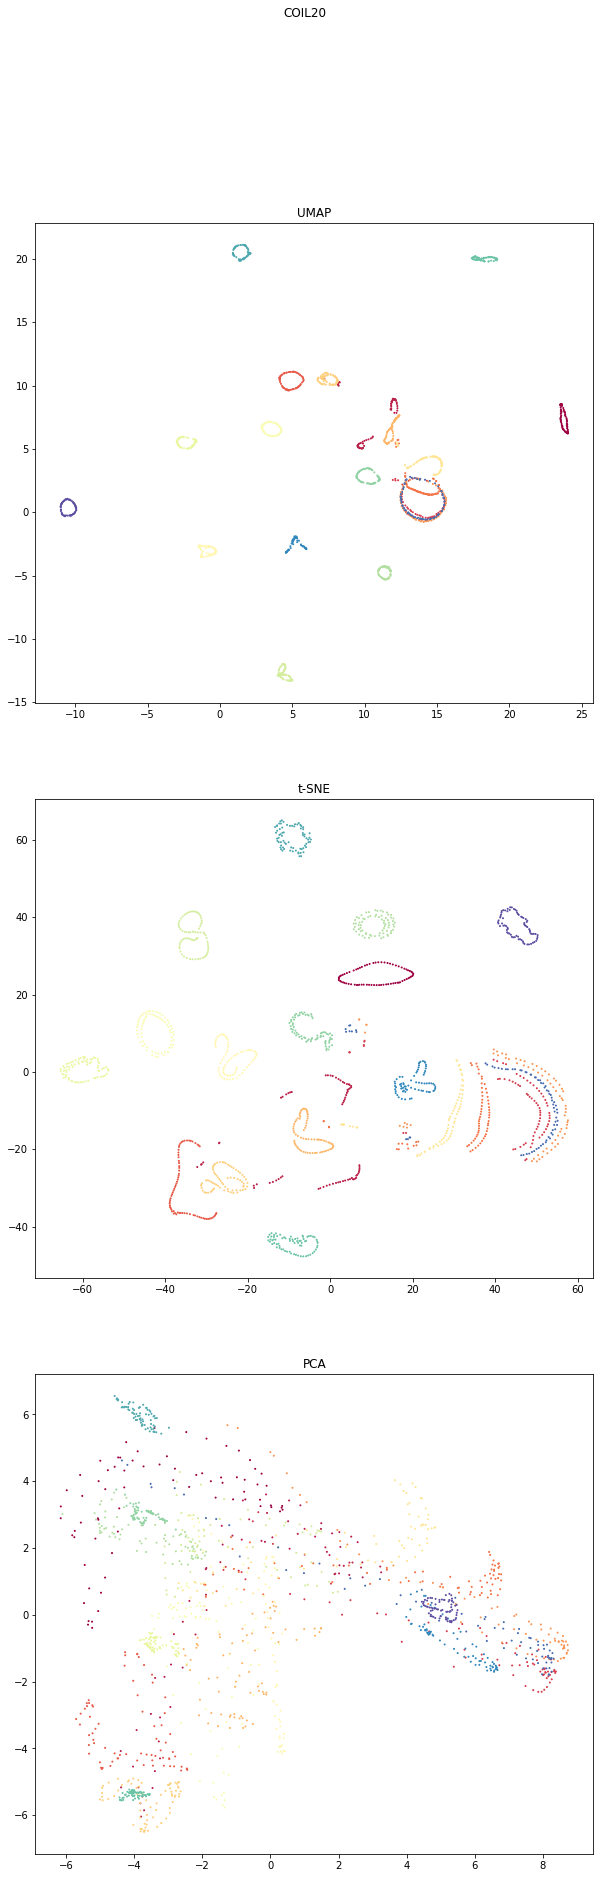

In [ ]:
coil20 = scipy.io.loadmat('./COIL20.mat')
c20x = coil20['X']
c20c = coil20['Y']
algorithms(c20x, "COIL20", c20c)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


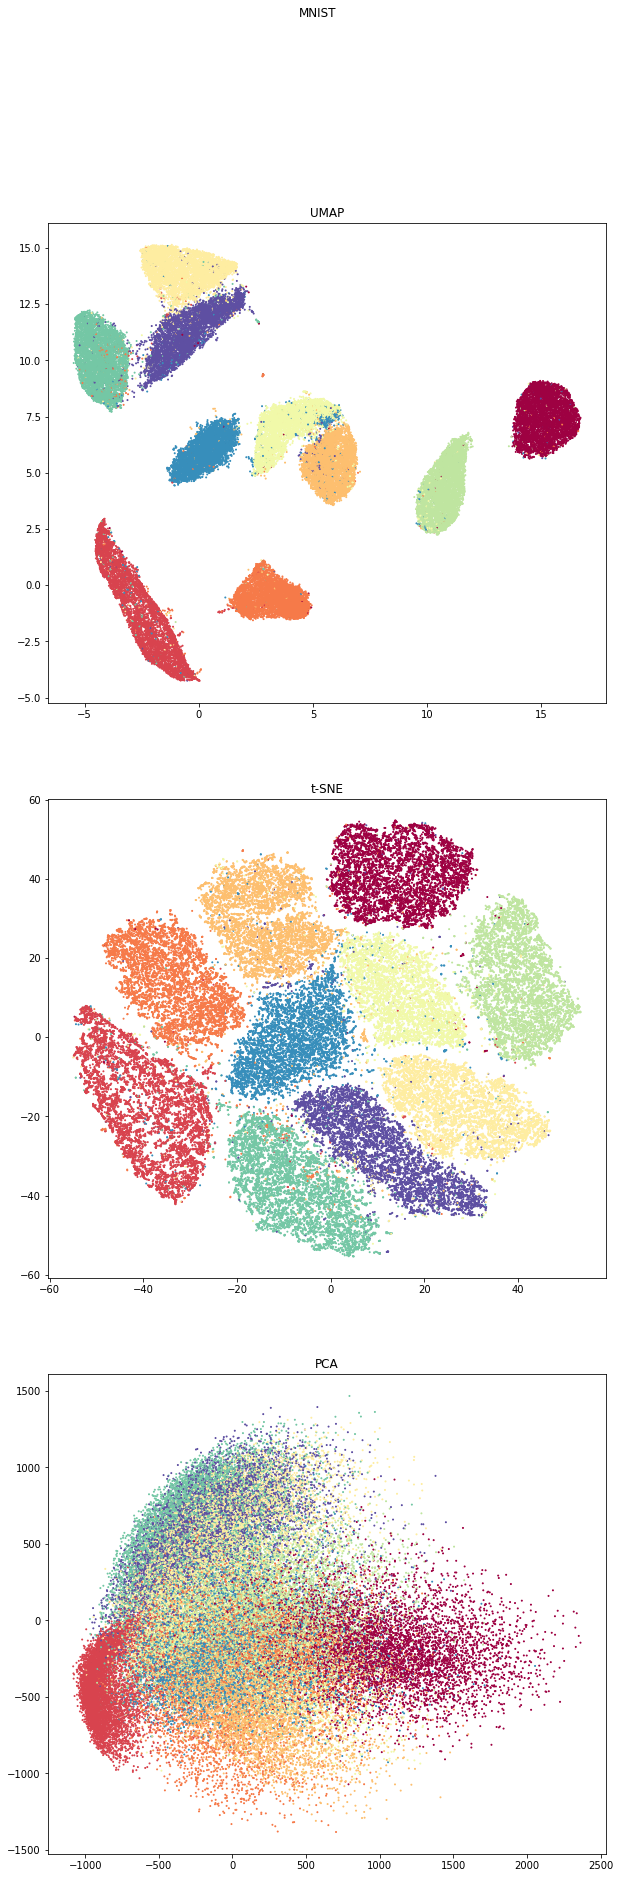

In [ ]:
(mtx, mtc), _ = mnist.load_data()
md = mtx.reshape(-1, 28*28)
algorithms(md, "MNIST", mtc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


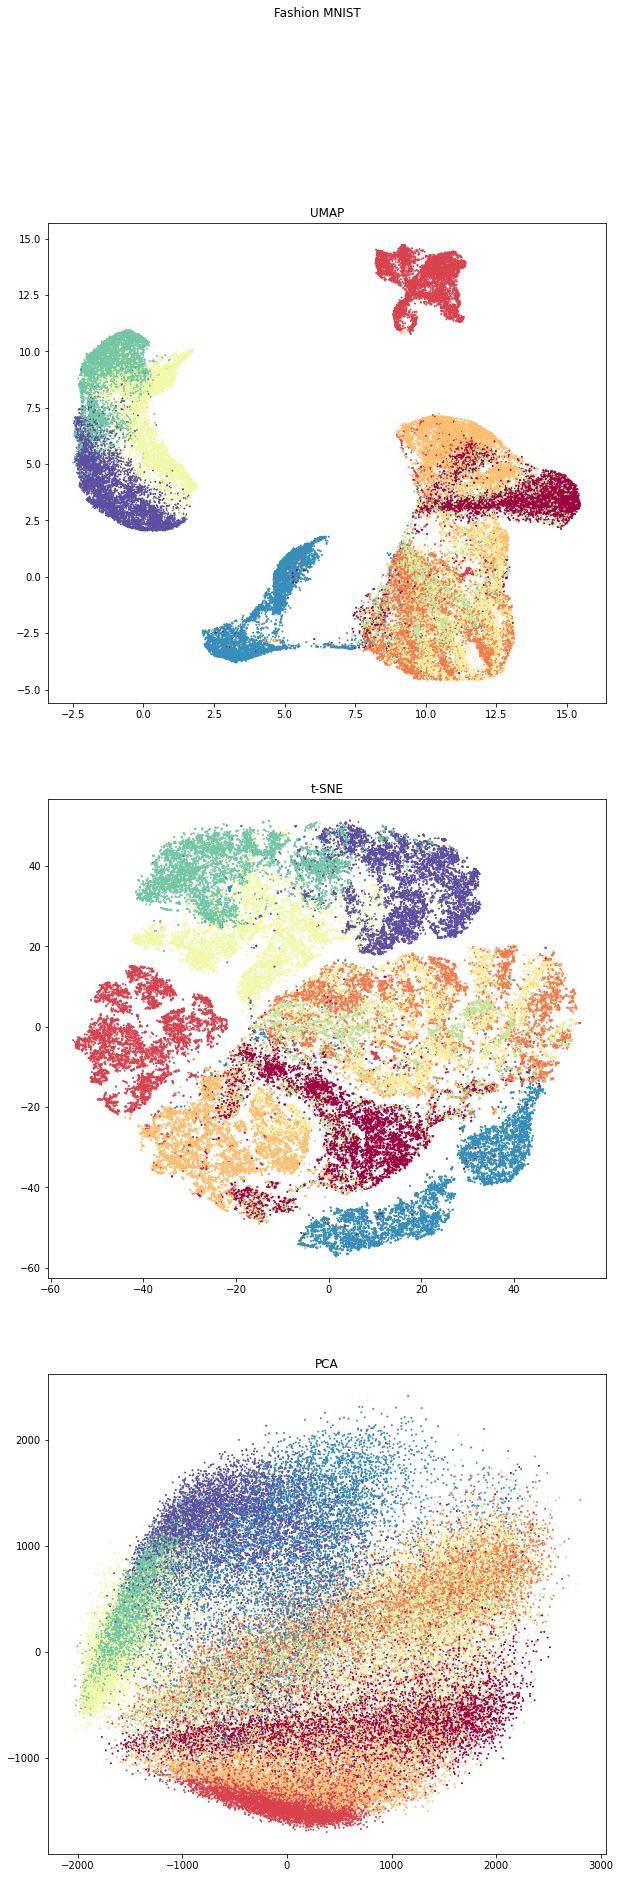

In [ ]:
(fmtx, fmtc), _ = fashion_mnist.load_data()
fmd = fmtx.reshape(-1, 28*28)
algorithms(fmd, "Fashion MNIST", fmtc)

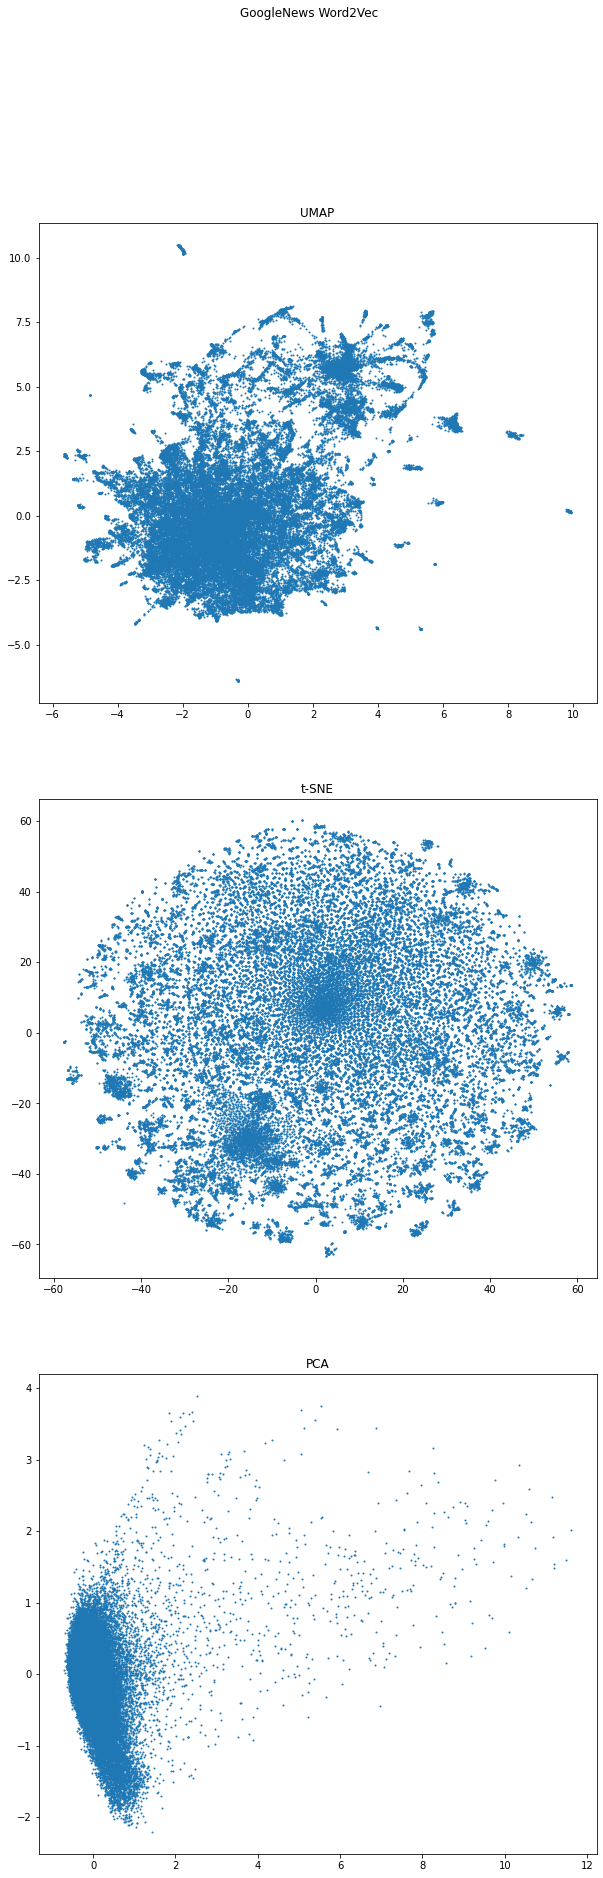

In [9]:
gn = models.KeyedVectors.load_word2vec_format(
    './GoogleNews-vectors-negative300.bin', binary=True, limit=50000)
algorithms(gn.vectors, "GoogleNews Word2Vec", None)